# Compare Biomass changes between high and low Ice Fraction with those changes in Ice Fraction

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib
# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import os

%matplotlib inline
from glob import glob
import dask
import esmlab
import pop_tools 
from statistics import mean

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Import phytoplankton biomass information

In [5]:
file = '/glade/u/home/gabyn/scratch/SPECTRA/nc_files/'
ds_spring= xr.open_mfdataset(f'{file}/regrid_spring_phyto_bmss_62yr.nc')
ds_summer= xr.open_mfdataset(f'{file}/regrid_summer_phyto_bmss_62yr.nc')
ds_fall= xr.open_mfdataset(f'{file}/regrid_fall_phyto_bmss_62yr.nc')
ds_winter= xr.open_mfdataset(f'{file}/regrid_winter_phyto_bmss_62yr.nc')

	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/regrid_spring_phyto_bmss_62yr.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/regrid_spring_phyto_bmss_62yr.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset lon
			found dataset lat
			found dataset year
			found dataset phytoC_spring_bm
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x10000 ext_ncid 0x10000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/regrid_spring_phyto_bmss_62yr.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 4 natts: 0
		 DIMENSION - dimid: 0 name: lon len: 360 unlimited: 0
		 DIMENSION - dimid: 1 name: lat len: 180 unlimited: 0
		 DIMENSION - dimid: 2 name: year len: 62 unlimited: 0
		 VARIABLE - varid: 0 name: lon ndims: 1 dimscale: 1 dimids: 0
		 VARIABLE - varid: 1 

In [6]:
%%time
phytoC_spring_bm = np.array(ds_spring.phytoC_spring_bm)
phytoC_summer_bm = np.array(ds_summer.phytoC_summer_bm)
phytoC_fall_bm = np.array(ds_fall.phytoC_fall_bm)
phytoC_winter_bm = np.array(ds_winter.phytoC_winter_bm)

_all: ncid 0x40000 varid 3
		NC4_inq_var_all: ncid 0x40000 varid 3
		NC4_inq_var_all: ncid 0x40000 varid 3
		NC4_inq_var_all: ncid 0x40000 varid 3
		NC4_inq_var_all: ncid 0x40000 varid 3
		NC4_inq_dim: ncid 0x40000 dimid 2
		NC4_inq_dim: ncid 0x40000 dimid 1
		NC4_inq_dim: ncid 0x40000 dimid 0
		NC4_inq_dim: ncid 0x40000 dimid 2
		NC4_inq_dim: ncid 0x40000 dimid 1
		NC4_inq_dim: ncid 0x40000 dimid 0
		NC4_inq: ncid 0x40000
			nc4_att_list_add: name CDI 
			nc4_att_list_add: name Conventions 
			nc4_att_list_add: name NCO 
			nc4_att_list_add: name history 
			nc4_att_list_add: name CDO 
		nc_inq_attname: ncid 0x40000 varid -1 attnum 0
		nc_inq_attname: ncid 0x40000 varid -1 attnum 1
		nc_inq_attname: ncid 0x40000 varid -1 attnum 2
		nc_inq_attname: ncid 0x40000 varid -1 attnum 3
		nc_inq_attname: ncid 0x40000 varid -1 attnum 4
		NC4_inq_att: ncid 0x40000 varid -1 name CDI
			nc4_get_att: ncid 0x40000 varid -1 name CDI attnum -1 mem_type 0
			nc4_get_att: ncid 0x40000 varid -1 name CDI 

CPU times: user 31.3 ms, sys: 42.9 ms, total: 74.2 ms
Wall time: 97.3 ms


		NC4_inq_var_all: ncid 0x30000 varid 3
		NC4_inq_var_all: ncid 0x30000 varid 3
		NC4_inq_dim: ncid 0x30000 dimid 2
		NC4_inq_dim: ncid 0x30000 dimid 1
		NC4_inq_dim: ncid 0x30000 dimid 0
		NC4_inq_dim: ncid 0x30000 dimid 2
		NC4_inq_dim: ncid 0x30000 dimid 1
		NC4_inq_dim: ncid 0x30000 dimid 0
		NC4_inq_var_all: ncid 0x30000 varid 3
		NC4_inq_var_all: ncid 0x30000 varid 3
		NC4_inq_dim: ncid 0x30000 dimid 2
		NC4_inq_dim: ncid 0x30000 dimid 1
		NC4_inq_dim: ncid 0x30000 dimid 0
		NC4_inq_var_all: ncid 0x30000 varid 3
		NC4_inq_var_all: ncid 0x30000 varid 3
		NC4_inq_dim: ncid 0x30000 dimid 2
		NC4_inq_dim: ncid 0x30000 dimid 1
		NC4_inq_dim: ncid 0x30000 dimid 0
		NC4_inq_var_all: ncid 0x30000 varid 3
			NC4_get_vars: var->hdr.name phytoC_fall_bm mem_nc_type 5
		NC4_inq_var_all: ncid 0x30000 varid 3
		NC4_inq_var_all: ncid 0x30000 varid 3
		NC4_inq_dim: ncid 0x30000 dimid 2
		NC4_inq_dim: ncid 0x30000 dimid 1
		NC4_inq_dim: ncid 0x30000 dimid 0
		NC4_inq_att: ncid 0x30000 varid 3 name

## Import high vs low years in NO3, temp and Ice

In [7]:
low_no3_years_arctic = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_no3_years_arctic.npy')
high_no3_years_arctic = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_no3_years_arctic.npy')
low_ice_years_arctic = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_ice_years_arctic.npy')
high_ice_years_arctic = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_ice_years_arctic.npy')
cold_years_arctic = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_temp_years_arctic.npy')
warm_years_arctic = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_temp_years_arctic.npy')

## Temperature

In [8]:
%%time
temp_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_TEMP.*.nc', recursive=True))
ds_01= xr.open_mfdataset(temp_inds[1::],concat_dim='time', combine='nested')

temp_ds_inter = np.empty([62,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    temp_ds_inter[i,:,:,:] = ds_01.TEMP[x[i]:x[i]+12,0,:,:]

CPU times: user 10.7 s, sys: 9.9 s, total: 20.6 s
Wall time: 46.8 s


In [9]:
cold_warm_years_summer_diff = np.nanmean(phytoC_summer_bm[cold_years_arctic,:,:],axis=(0,1)) - np.nanmean(phytoC_summer_bm[warm_years_arctic,:,:],axis=(0,1)) 

cold_warm_years_spring_diff = np.nanmean(phytoC_spring_bm[cold_years_arctic,:,:],axis=(0,1))  - np.nanmean(phytoC_spring_bm[warm_years_arctic,:,:],axis=(0,1))  

cold_warm_years_fall_diff = np.nanmean(phytoC_fall_bm[cold_years_arctic,:,:],axis=(0,1))  - np.nanmean(phytoC_fall_bm[warm_years_arctic,:,:],axis=(0,1)) 

cold_warm_years_winter_diff = np.nanmean(phytoC_winter_bm[cold_years_arctic,:,:],axis=(0,1))  - np.nanmean(phytoC_winter_bm[warm_years_arctic,:,:],axis=(0,1))  

## Ecosystem Ice Fraction

In [10]:
%%time
temp_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_ECOSYS_IFRAC*.nc', recursive=True))
ds_02= xr.open_mfdataset(temp_inds[1::],concat_dim='time', combine='nested')

ECOSYS_IFRAC_ds_inter = np.empty([62,12,180,360])
ECOSYS_IFRAC_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    ECOSYS_IFRAC_ds_inter[i,:,:,:] = ds_02.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

CPU times: user 1.01 s, sys: 225 ms, total: 1.23 s
Wall time: 3.46 s


In [11]:
high_low_ice_years_summer_diff = np.nanmean(phytoC_summer_bm[high_ice_years_arctic,:,:],axis=(0,1))  - np.nanmean(phytoC_summer_bm[low_ice_years_arctic,:,:],axis=(0,1)) 

high_low_ice_years_spring_diff = np.nanmean(phytoC_spring_bm[high_ice_years_arctic,:,:],axis=(0,1))  - np.nanmean(phytoC_spring_bm[low_ice_years_arctic,:,:],axis=(0,1))  

high_low_ice_years_fall_diff = np.nanmean(phytoC_fall_bm[high_ice_years_arctic,:,:],axis=(0,1))  - np.nanmean(phytoC_fall_bm[low_ice_years_arctic,:,:],axis=(0,1))  

high_low_ice_years_winter_diff = np.nanmean(phytoC_winter_bm[high_ice_years_arctic,:,:],axis=(0,1))  - np.nanmean(phytoC_winter_bm[low_ice_years_arctic,:,:],axis=(0,1))  

## NO$_3$

In [12]:
%%time
NO3_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_NO3*.nc', recursive=True))
ds_03= xr.open_mfdataset(NO3_inds[1::],concat_dim='time', combine='nested')

NO3_ds_inter = np.empty([62,12,180,360])
NO3_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    NO3_ds_inter[i,:,:,:] = ds_03.NO3[x[i]:x[i]+12,0,:,:]

	NC4_close: ncid 0x10000
			nc4_close_hdf5_file: h5->path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/regrid_spring_phyto_bmss_62yr.nc abort 0
			nc4_rec_grp_HDF5_del: grp->name /
			closing HDF5 dataset 360287970189639680
			closing HDF5 dataset 360287970189639681
			closing HDF5 dataset 360287970189639682
			closing HDF5 dataset 360287970189639683
			nc4_close_netcdf4_file: h5->path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/regrid_spring_phyto_bmss_62yr.nc abort 0
			nc4_rec_grp_del: grp->name /
			att_free: name CDI 
			att_free: name Conventions 
			att_free: name NCO 
			att_free: name history 
			att_free: name CDO 
			att_free: name standard_name 
			att_free: name long_name 
			att_free: name units 
			att_free: name axis 
			att_free: name standard_name 
			att_free: name long_name 
			att_free: name units 
			att_free: name axis 
			att_free: name axis 
			att_free: name _FillValue 
			att_free: name missing_value 
	NC4_close: ncid 0x20000
			nc4_close_hdf5_file: h5->path

CPU times: user 10.5 s, sys: 10.5 s, total: 21 s
Wall time: 46.9 s


In [13]:
high_low_no3_years_summer_diff = np.nanmean(phytoC_summer_bm[high_no3_years_arctic,:,:],axis=(0,1))  - np.nanmean(phytoC_summer_bm[low_no3_years_arctic,:,:],axis=(0,1)) 

high_low_no3_years_spring_diff = np.nanmean(phytoC_spring_bm[high_no3_years_arctic,:,:],axis=(0,1))  - np.nanmean(phytoC_spring_bm[low_no3_years_arctic,:,:],axis=(0,1)) 

high_low_no3_years_fall_diff = np.nanmean(phytoC_fall_bm[high_no3_years_arctic,:,:],axis=(0,1))  - np.nanmean(phytoC_fall_bm[low_no3_years_arctic,:,:],axis=(0,1))  

high_low_no3_years_winter_diff = np.nanmean(phytoC_winter_bm[high_no3_years_arctic,:,:],axis=(0,1))  - np.nanmean(phytoC_winter_bm[low_no3_years_arctic,:,:],axis=(0,1)) 

## Now select low and highs for each environental paramter

In [14]:
high_low_ice =np.nanmean(ECOSYS_IFRAC_ds_inter[high_ice_years_arctic,:,:,:],axis=(0,1))-np.nanmean(ECOSYS_IFRAC_ds_inter[low_ice_years_arctic,:,:,:],axis=(0,1))
high_low_no3 =np.nanmean(NO3_ds_inter[high_ice_years_arctic,:,:,:],axis=(0,1))-np.nanmean(NO3_ds_inter[low_ice_years_arctic,:,:,:],axis=(0,1))
high_low_temp =np.nanmean(temp_ds_inter[high_ice_years_arctic,:,:,:],axis=(0,1))-np.nanmean(temp_ds_inter[low_ice_years_arctic,:,:,:],axis=(0,1))

## this is the actual values of the differnt regions that I want 
Arctic Regions

|Region| Latitude | Longitude | Matrix Inputs       |
|------|----------|-----------|---------------------|
|`ao`  |170:180   |:          |`[:,170:180,:]`      |
|`cs`  |149:170   |0:25       |`[:,149:170,0:25]`   |
|`bs`  |149:170   | 25:55     |`[:,149:170,25:55]`  |
|`ca`  |149:170   |55:80     |`[:,149:170,55:110]` |
|`bb`  |149:170   |80:135    |`[:,149:170,110:135]`|
|`ess` |149:170   |325:360    |`[:149:170,325:360]` |
|`ls`  |149:170   |270:325    |`[:,149:170,270:325]`|
|`ks`  |149:170   |233:270    |`[:,149:170,233:270]`|
|`bts` |149:170   |200:233    |`[:,149:170,205:233]`|
|`ns`  |149:170   |155:200    |`[:,149:170,155:205]`|

| Initials  | Name                       | Latitude          | Longitude             |
|-----------|----------------------------|-------------------|-----------------------|
| `ao`      | Central Arctic             | $90^oN$ to $80^oN$ |  All                 |
| `cs`      | Chukchi Sea                | $80^oN$ to $60^oN$ |$-180^o$ to $-155^oW$ |
| `bs`      | Beaufort Sea               | $80^oN$ to $60^oN$ |$-155^oW$ to $-125^oW$|
| `ca`      | Canadian Archipelago       | $80^oN$ to $60^oN$ |$-125^oW$ to $-100^oW$ |
| `bb`      | Baffin Sea                 | $80^oN$ to $60^oN$ |$-100^oW$ to $-45^oW$  |                      
| `ess`     | Eastern Siberian Sea       | $80^oN$ to $60^oN$ |$145^oE$ to $180^o$   |                       
| `ls`      | Laptev Sea                 | $80^oN$ to $60^oN$ |$90^oE$ to $145^oE$   |                      
| `ks`      | Kara Sea                   | $80^oN$ to $60^oN$ |$53^oE$ to $90^oE$    |                      
| `bts`     | Barents Sea                | $80^oN$ to $60^oN$ |$20^oE$ to $53^oE$    |                      
| `ns`      | Nordic Sea                 | $80^oN$ to $60^oN$ |$-45^oW$ to $20^oE$   | 

In [74]:
import matplotlib.pyplot as plt

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Scatter plot --For each region and season throughout the Arctic Ocean --  

In [75]:
variable = 'Ice'
phyto_variable = 'biomass'
caption = 'Ice Fraction (high-low)'

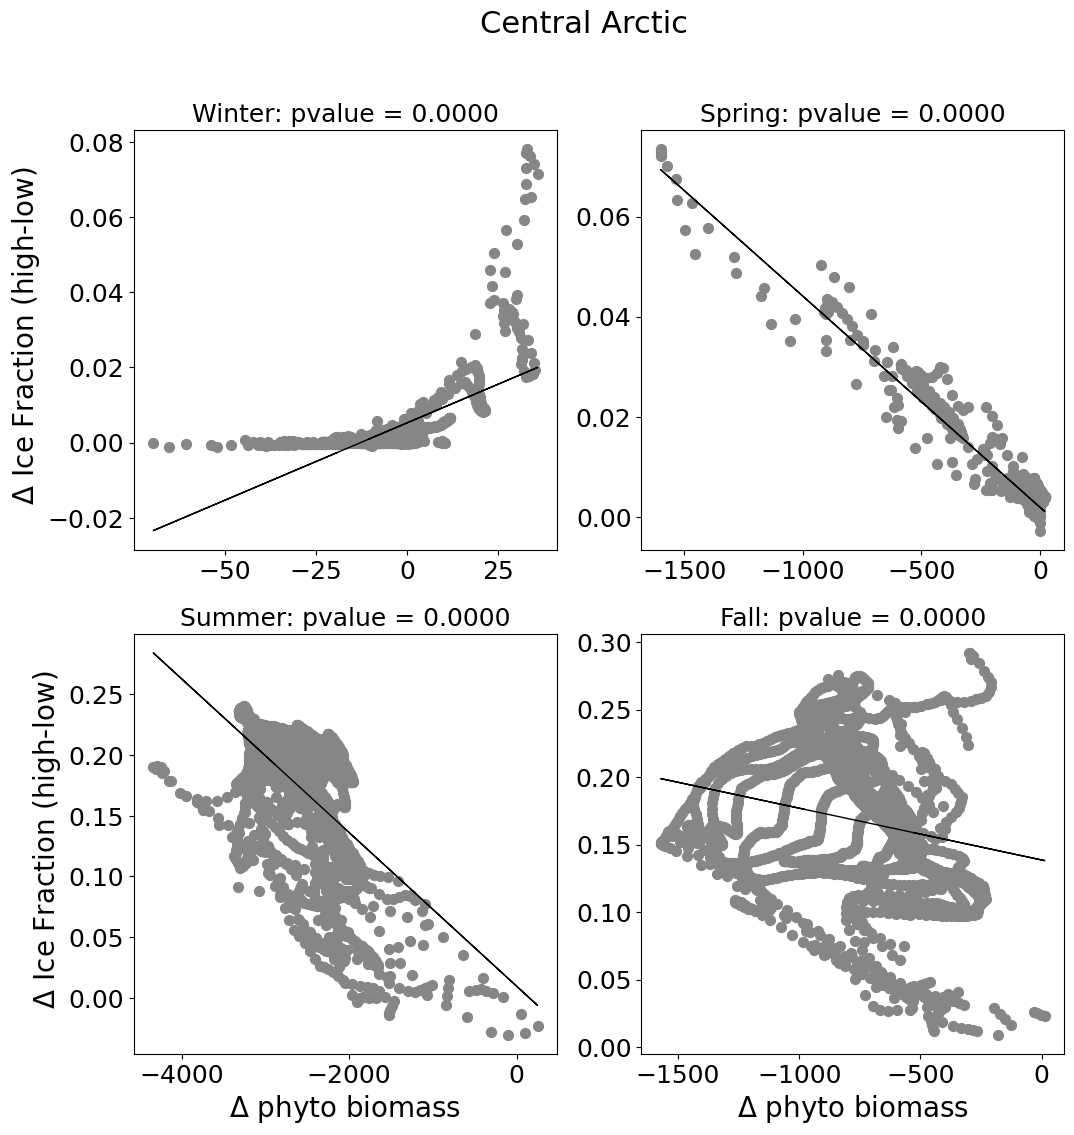

In [76]:
import matplotlib
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(2,2,1) 
X1 = high_low_ice_years_winter_diff[170:180,:].flatten()
Y1 = np.nanmean(high_low_ice[list(range(2)) + [-1],170:180,:],axis=0).flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Winter: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(2,2,2) 
X2 = high_low_ice_years_spring_diff[170:180,:].flatten()
Y2 = np.nanmean(high_low_ice[2:5,170:180,:],axis=0).flatten()
XX2= X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2 = Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Spring: pvalue = {res2.pvalue:.4f}')

ax = fig.add_subplot(2,2,3) 
ax.set_xlabel('$\u0394$ phyto biomass')
ax.set_ylabel(f' $\u0394$ {caption}')
X3 = high_low_ice_years_summer_diff[170:180,:].flatten()
Y3 = np.nanmean(high_low_ice[5:8,170:180,:],axis=0).flatten()
XX3= X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Summer: pvalue = {res3.pvalue:.4f}')

ax = fig.add_subplot(2,2,4) 
ax.set_xlabel('$\u0394$ phyto biomass')
X4 = high_low_ice_years_fall_diff[170:180,:].flatten()
Y4 = np.nanmean(high_low_ice[8:11,170:180,:],axis=0).flatten()
XX4= X4[~np.isnan(Y4) & ~np.isnan(X4)]
YY4 = Y4[~np.isnan(Y4) & ~np.isnan(X4)]
res4 = stats.linregress(XX4, YY4)
YYY4 = res4.intercept + res4.slope*XX4
ax.scatter(XX4, YY4, color = cmap1(4), s = 50)
ax.plot(XX4, YYY4, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Fall: pvalue = {res4.pvalue:.4f}')
region = 'Central Arctic'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_quarterly_scatter_{variable}_{phyto_variable}_diff.png',dpi=600, bbox_inches='tight')

In [77]:
res1

LinregressResult(slope=0.00041132977861786565, intercept=0.0052376645464372405, rvalue=0.6370820523202045, pvalue=0.0, stderr=8.612436217556317e-06)

In [78]:
res2

LinregressResult(slope=-4.2186644318398466e-05, intercept=0.0019357452579017273, rvalue=-0.960432870890093, pvalue=0.0, stderr=2.1171080055714725e-07)

In [79]:
res3

LinregressResult(slope=-6.331533921595928e-05, intercept=0.009512172611524178, rvalue=-0.6156617635449582, pvalue=0.0, stderr=1.402460268062277e-06)

In [80]:
res4

LinregressResult(slope=-3.8372400896266594e-05, intercept=0.13862212356364087, rvalue=-0.21113989782308093, pvalue=5.586947171381404e-35, stderr=3.0742388589024313e-06)

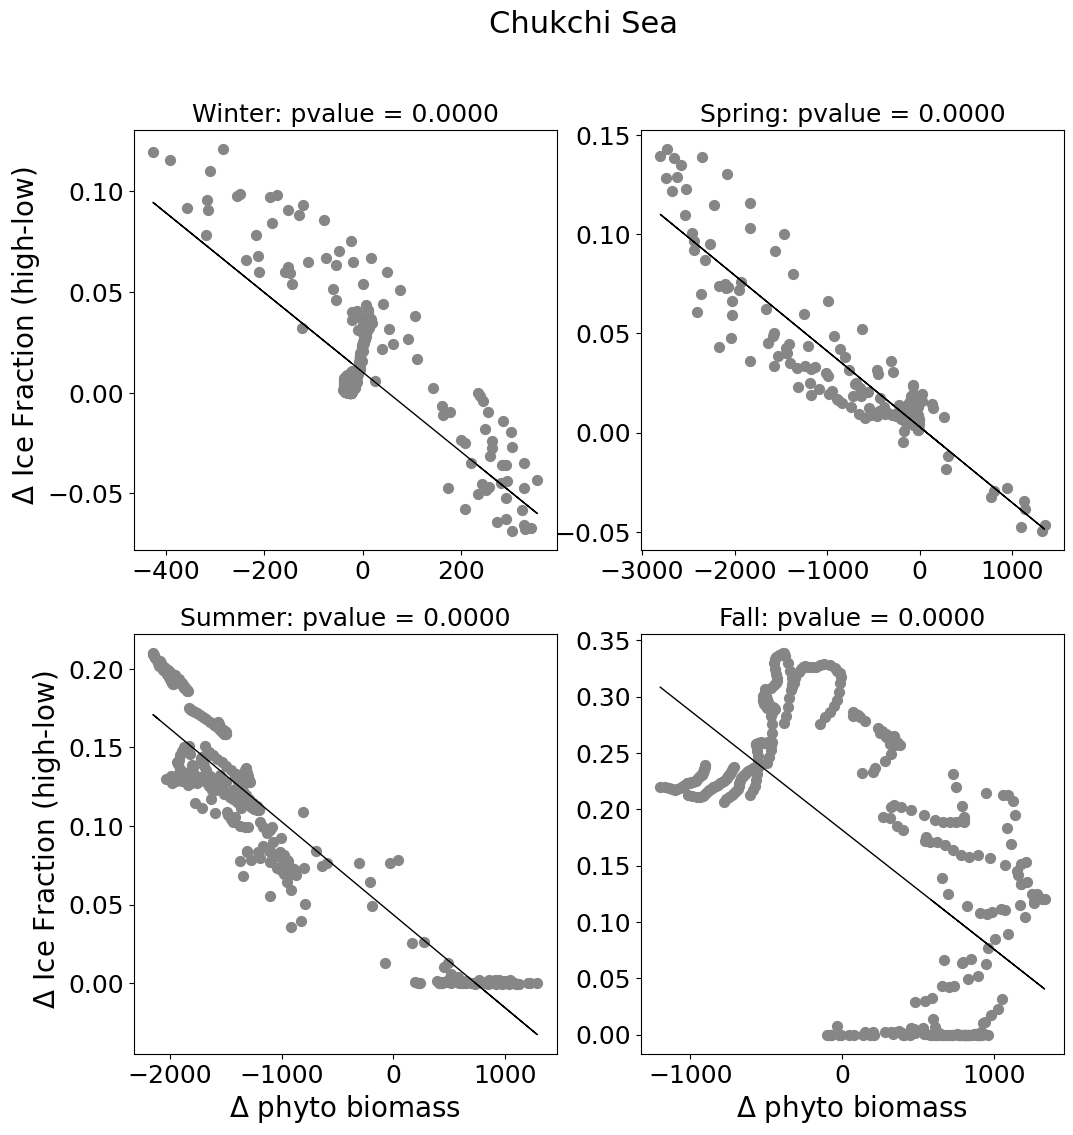

In [81]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(2,2,1) 
X1 = high_low_ice_years_winter_diff[149:170,0:25].flatten()
Y1 = np.nanmean(high_low_ice[list(range(2)) + [-1],149:170,0:25],axis=0).flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Winter: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(2,2,2) 
X2 = high_low_ice_years_spring_diff[149:170,0:25].flatten()
Y2 = np.nanmean(high_low_ice[2:5,149:170,0:25],axis=0).flatten()
XX2= X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2 = Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Spring: pvalue = {res2.pvalue:.4f}')

ax = fig.add_subplot(2,2,3) 
ax.set_xlabel('$\u0394$ phyto biomass')
ax.set_ylabel(f' $\u0394$ {caption}')
X3 = high_low_ice_years_summer_diff[149:170,0:25].flatten()
Y3 = np.nanmean(high_low_ice[5:8,149:170,0:25],axis=0).flatten()
XX3= X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Summer: pvalue = {res3.pvalue:.4f}')

ax = fig.add_subplot(2,2,4) 
ax.set_xlabel('$\u0394$ phyto biomass')
X4 = high_low_ice_years_fall_diff[149:170,0:25].flatten()
Y4 = np.nanmean(high_low_ice[8:11,149:170,0:25],axis=0).flatten()
XX4= X4[~np.isnan(Y4) & ~np.isnan(X4)]
YY4 = Y4[~np.isnan(Y4) & ~np.isnan(X4)]
res4 = stats.linregress(XX4, YY4)
YYY4 = res4.intercept + res4.slope*XX4
ax.scatter(XX4, YY4, color = cmap1(4), s = 50)
ax.plot(XX4, YYY4, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Fall: pvalue = {res4.pvalue:.4f}')
region = 'Chukchi Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_quarterly_scatter_{variable}_{phyto_variable}_diff.png',dpi=600, bbox_inches='tight')

In [82]:
res1

LinregressResult(slope=-0.00019751749332432345, intercept=0.010321718282496594, rvalue=-0.737053560878015, pvalue=1.4320576929496044e-63, stderr=9.519025346926636e-06)

In [83]:
res2

LinregressResult(slope=-3.824177743878622e-05, intercept=0.0028335470790768324, rvalue=-0.9323061157101536, pvalue=5.777482989559631e-162, stderr=7.797186691276097e-07)

In [84]:
res3

LinregressResult(slope=-5.912280634646971e-05, intercept=0.043680587242691124, rvalue=-0.9410223745769205, pvalue=1.8899835536750773e-172, stderr=1.1172740645093694e-06)

In [85]:
res4

LinregressResult(slope=-0.00010577451202597589, intercept=0.1816051486118091, rvalue=-0.6389305322134684, pvalue=3.754109129010701e-43, stderr=6.693430511184709e-06)

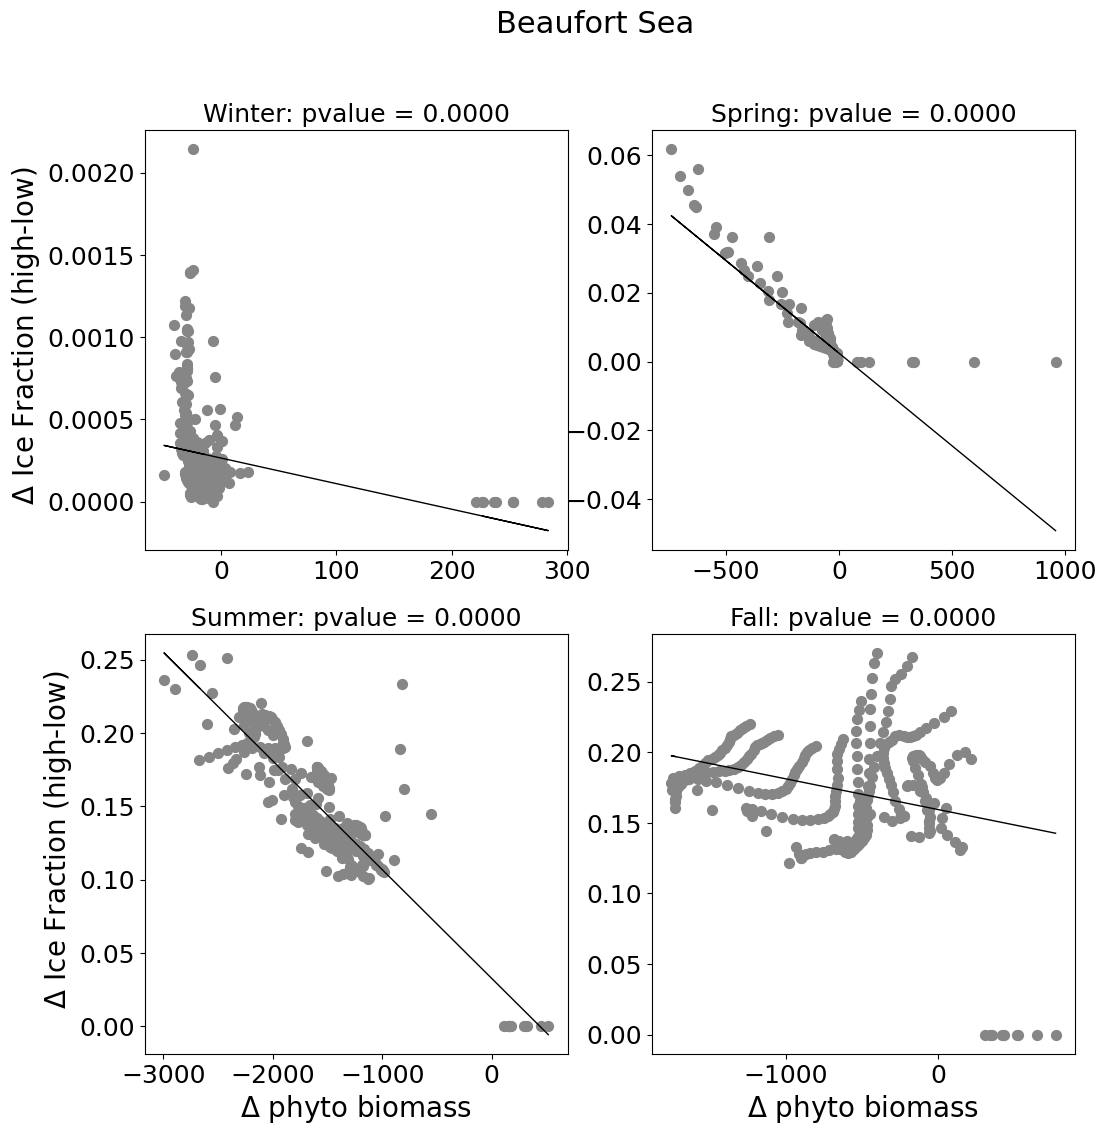

In [86]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(2,2,1) 
X1 = high_low_ice_years_winter_diff[149:170,25:55].flatten()
Y1 = np.nanmean(high_low_ice[list(range(2)) + [-1],149:170,25:55],axis=0).flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Winter: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(2,2,2) 
X2 = high_low_ice_years_spring_diff[149:170,25:55].flatten()
Y2 = np.nanmean(high_low_ice[2:5,149:170,25:55],axis=0).flatten()
XX2= X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2 = Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Spring: pvalue = {res2.pvalue:.4f}')

ax = fig.add_subplot(2,2,3) 
ax.set_xlabel('$\u0394$ phyto biomass')
ax.set_ylabel(f' $\u0394$ {caption}')
X3 = high_low_ice_years_summer_diff[149:170,25:55].flatten()
Y3 = np.nanmean(high_low_ice[5:8,149:170,25:55],axis=0).flatten()
XX3= X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Summer: pvalue = {res3.pvalue:.4f}')

ax = fig.add_subplot(2,2,4) 
ax.set_xlabel('$\u0394$ phyto biomass')
X4 = high_low_ice_years_fall_diff[149:170,25:55].flatten()
Y4 = np.nanmean(high_low_ice[8:11,149:170,25:55],axis=0).flatten()
XX4= X4[~np.isnan(Y4) & ~np.isnan(X4)]
YY4 = Y4[~np.isnan(Y4) & ~np.isnan(X4)]
res4 = stats.linregress(XX4, YY4)
YYY4 = res4.intercept + res4.slope*XX4
ax.scatter(XX4, YY4, color = cmap1(4), s = 50)
ax.plot(XX4, YYY4, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Fall: pvalue = {res4.pvalue:.4f}')
region = 'Beaufort Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_quarterly_scatter_{variable}_{phyto_variable}_diff.png',dpi=600, bbox_inches='tight')

In [87]:
res1

LinregressResult(slope=-1.5552043536598964e-06, intercept=0.0002653524761025978, rvalue=-0.23528781749874056, pvalue=4.214068327513495e-05, stderr=3.740331525468048e-07)

In [88]:
res2

LinregressResult(slope=-5.391253903101385e-05, intercept=0.002455389666226985, rvalue=-0.862809202559848, pvalue=2.1652875742791468e-89, stderr=1.8391226229068367e-06)

In [89]:
res3

LinregressResult(slope=-7.416461509545812e-05, intercept=0.03256064918956823, rvalue=-0.884451687738446, pvalue=1.1668133699974404e-99, stderr=2.2781689648670603e-06)

In [90]:
res4

LinregressResult(slope=-2.184151478227068e-05, intercept=0.15936416432361017, rvalue=-0.28134065733958524, pvalue=8.308114520603459e-07, stderr=4.337436105509328e-06)

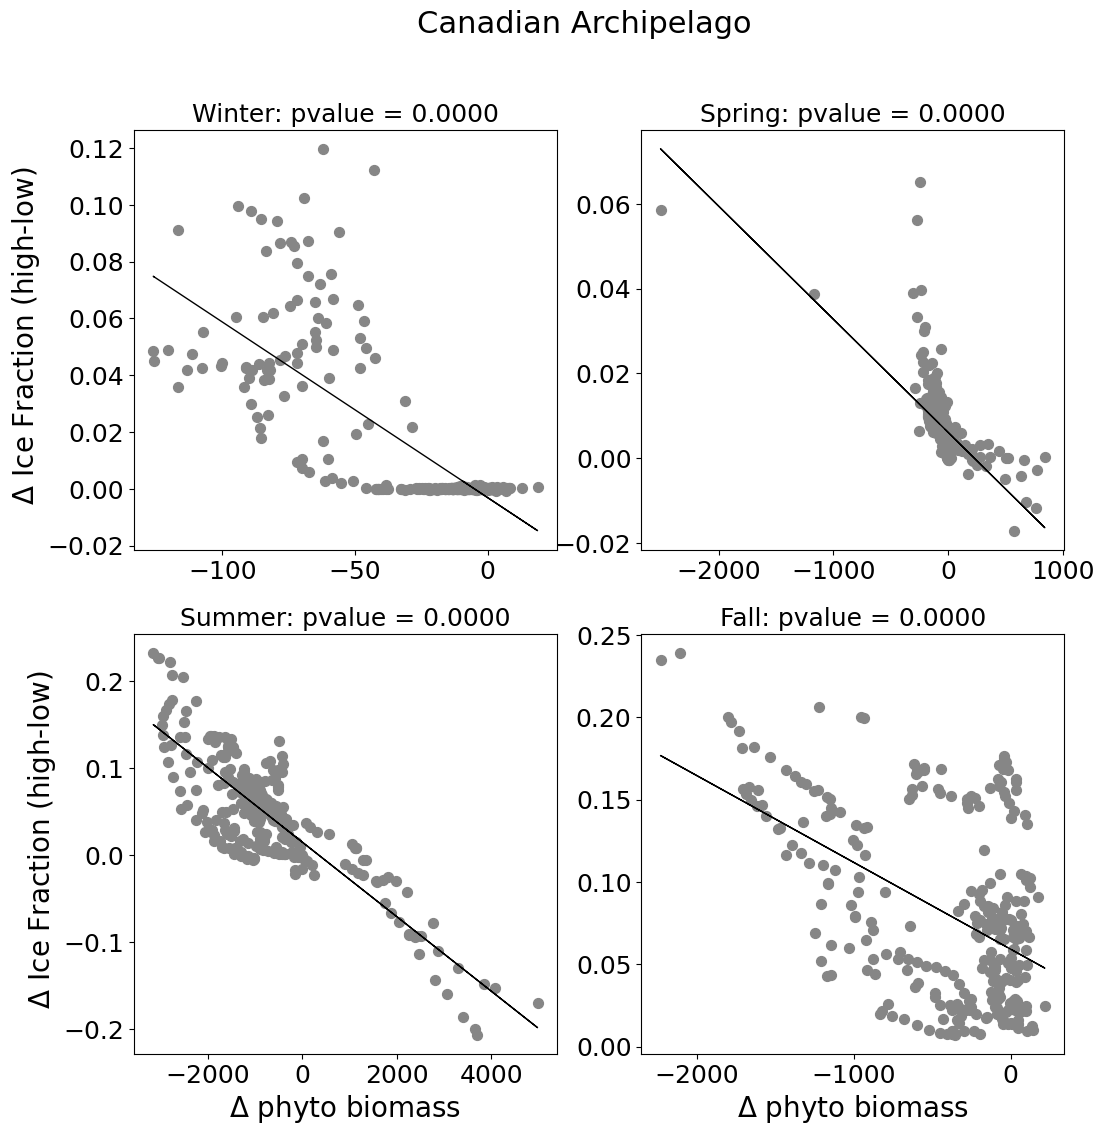

In [91]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(2,2,1) 
X1 = high_low_ice_years_winter_diff[149:170,55:110].flatten()
Y1 = np.nanmean(high_low_ice[list(range(2)) + [-1],149:170,55:110],axis=0).flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Winter: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(2,2,2) 
X2 = high_low_ice_years_spring_diff[149:170,55:110].flatten()
Y2 = np.nanmean(high_low_ice[2:5,149:170,55:110],axis=0).flatten()
XX2= X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2 = Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Spring: pvalue = {res2.pvalue:.4f}')

ax = fig.add_subplot(2,2,3) 
ax.set_xlabel('$\u0394$ phyto biomass')
ax.set_ylabel(f' $\u0394$ {caption}')
X3 = high_low_ice_years_summer_diff[149:170,55:110].flatten()
Y3 = np.nanmean(high_low_ice[5:8,149:170,55:110],axis=0).flatten()
XX3= X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Summer: pvalue = {res3.pvalue:.4f}')

ax = fig.add_subplot(2,2,4) 
ax.set_xlabel('$\u0394$ phyto biomass')
X4 = high_low_ice_years_fall_diff[149:170,55:110].flatten()
Y4 = np.nanmean(high_low_ice[8:11,149:170,55:110],axis=0).flatten()
XX4= X4[~np.isnan(Y4) & ~np.isnan(X4)]
YY4 = Y4[~np.isnan(Y4) & ~np.isnan(X4)]
res4 = stats.linregress(XX4, YY4)
YYY4 = res4.intercept + res4.slope*XX4
ax.scatter(XX4, YY4, color = cmap1(4), s = 50)
ax.plot(XX4, YYY4, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Fall: pvalue = {res4.pvalue:.4f}')
region = 'Canadian Archipelago'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_quarterly_scatter_{variable}_{phyto_variable}_diff.png',dpi=600, bbox_inches='tight')

In [92]:
res1

LinregressResult(slope=-0.0006183680286279646, intercept=-0.0031058980100207648, rvalue=-0.7646443124051264, pvalue=4.393227300061859e-57, stderr=3.065699497386823e-05)

In [93]:
res2

LinregressResult(slope=-2.663317277025026e-05, intercept=0.006110885799564259, rvalue=-0.6674906603524956, pvalue=6.817908596397042e-39, stderr=1.747682030624337e-06)

In [94]:
res3

LinregressResult(slope=-4.2804898096347906e-05, intercept=0.014709438190521427, rvalue=-0.8480184795375472, pvalue=1.1219134869841581e-81, stderr=1.5735761957951496e-06)

In [95]:
res4

LinregressResult(slope=-5.2636669295121335e-05, intercept=0.05914096737819344, rvalue=-0.49501414857776493, pvalue=2.1483586360919297e-19, stderr=5.434806967313871e-06)

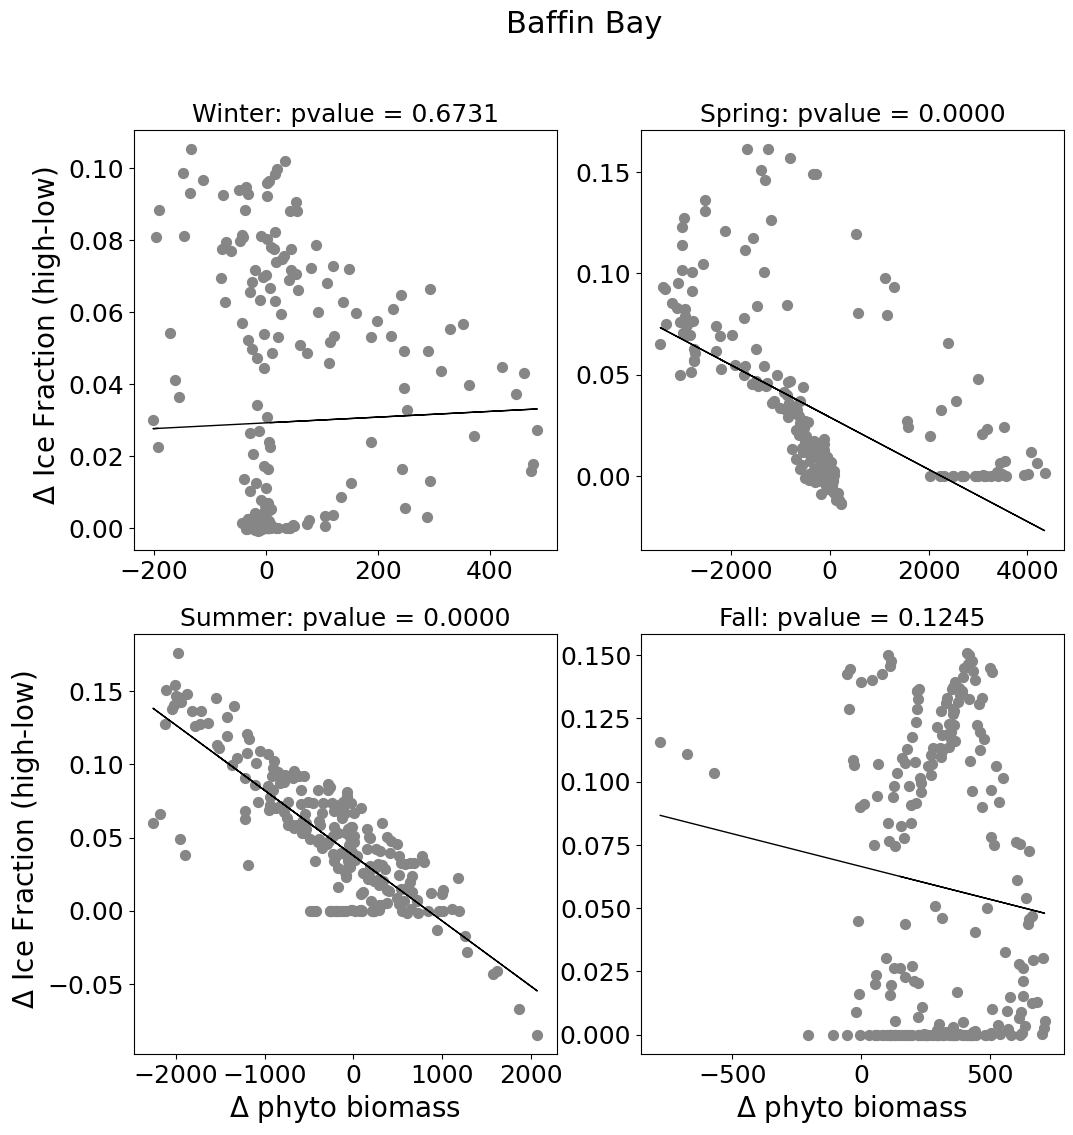

In [96]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(2,2,1) 
X1 = high_low_ice_years_winter_diff[149:170,110:135].flatten()
Y1 = np.nanmean(high_low_ice[list(range(2)) + [-1],149:170,110:135],axis=0).flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Winter: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(2,2,2) 
X2 = high_low_ice_years_spring_diff[149:170,110:135].flatten()
Y2 = np.nanmean(high_low_ice[2:5,149:170,110:135],axis=0).flatten()
XX2= X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2 = Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Spring: pvalue = {res2.pvalue:.4f}')

ax = fig.add_subplot(2,2,3) 
ax.set_xlabel('$\u0394$ phyto biomass')
ax.set_ylabel(f' $\u0394$ {caption}')
X3 = high_low_ice_years_summer_diff[149:170,110:135].flatten()
Y3 = np.nanmean(high_low_ice[5:8,149:170,110:135],axis=0).flatten()
XX3= X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Summer: pvalue = {res3.pvalue:.4f}')

ax = fig.add_subplot(2,2,4) 
ax.set_xlabel('$\u0394$ phyto biomass')
X4 = high_low_ice_years_fall_diff[149:170,110:135].flatten()
Y4 = np.nanmean(high_low_ice[8:11,149:170,110:135],axis=0).flatten()
XX4= X4[~np.isnan(Y4) & ~np.isnan(X4)]
YY4 = Y4[~np.isnan(Y4) & ~np.isnan(X4)]
res4 = stats.linregress(XX4, YY4)
YYY4 = res4.intercept + res4.slope*XX4
ax.scatter(XX4, YY4, color = cmap1(4), s = 50)
ax.plot(XX4, YYY4, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Fall: pvalue = {res4.pvalue:.4f}')
region = 'Baffin Bay'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_quarterly_scatter_{variable}_{phyto_variable}_diff.png',dpi=600, bbox_inches='tight')

In [97]:
res1

LinregressResult(slope=7.952593324323018e-06, intercept=0.029221147912090017, rvalue=0.02760135963762621, pvalue=0.6731351217396413, stderr=1.882802976922881e-05)

In [98]:
res2

LinregressResult(slope=-1.2868580790470035e-05, intercept=0.028978701749338066, rvalue=-0.547485685759308, pvalue=7.406198713226842e-20, stderr=1.2858178100956119e-06)

In [99]:
res3

LinregressResult(slope=-4.4613321777252834e-05, intercept=0.03772469535917079, rvalue=-0.8290724064533622, pvalue=5.217741487649159e-61, stderr=1.966915529190654e-06)

In [100]:
res4

LinregressResult(slope=-2.5912962764668016e-05, intercept=0.06646710157357329, rvalue=-0.1002883286405282, pvalue=0.12445154708927009, stderr=1.680597367472222e-05)

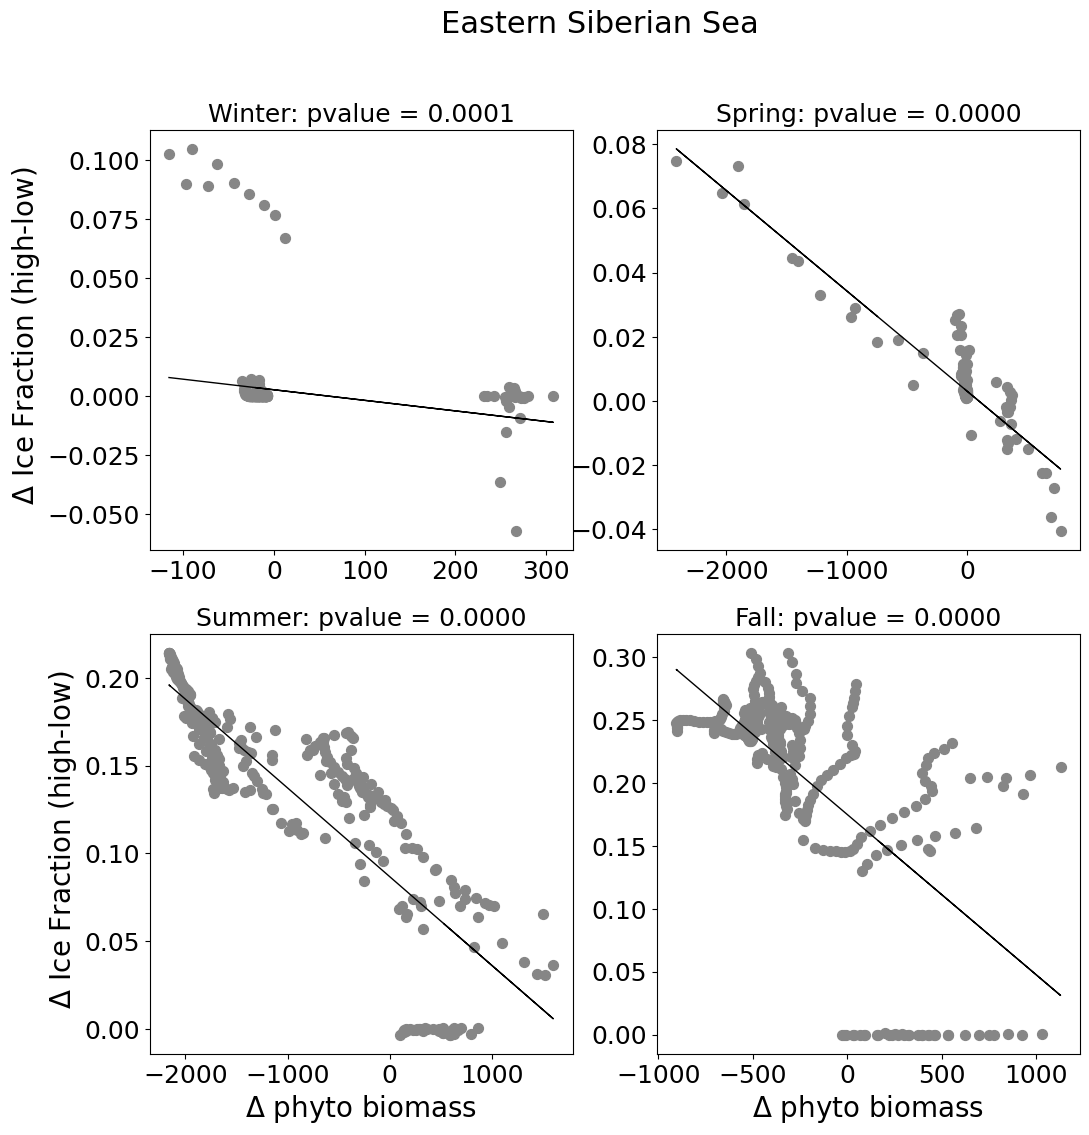

In [101]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(2,2,1) 
X1 = high_low_ice_years_winter_diff[149:170,325:360].flatten()
Y1 = np.nanmean(high_low_ice[list(range(2)) + [-1],149:170,325:360],axis=0).flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Winter: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(2,2,2) 
X2 = high_low_ice_years_spring_diff[149:170,325:360].flatten()
Y2 = np.nanmean(high_low_ice[2:5,149:170,325:360],axis=0).flatten()
XX2= X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2 = Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Spring: pvalue = {res2.pvalue:.4f}')

ax = fig.add_subplot(2,2,3) 
ax.set_xlabel('$\u0394$ phyto biomass')
ax.set_ylabel(f' $\u0394$ {caption}')
X3 = high_low_ice_years_summer_diff[149:170,325:360].flatten()
Y3 = np.nanmean(high_low_ice[5:8,149:170,325:360],axis=0).flatten()
XX3= X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Summer: pvalue = {res3.pvalue:.4f}')

ax = fig.add_subplot(2,2,4) 
ax.set_xlabel('$\u0394$ phyto biomass')
X4 = high_low_ice_years_fall_diff[149:170,325:360].flatten()
Y4 = np.nanmean(high_low_ice[8:11,149:170,325:360],axis=0).flatten()
XX4= X4[~np.isnan(Y4) & ~np.isnan(X4)]
YY4 = Y4[~np.isnan(Y4) & ~np.isnan(X4)]
res4 = stats.linregress(XX4, YY4)
YYY4 = res4.intercept + res4.slope*XX4
ax.scatter(XX4, YY4, color = cmap1(4), s = 50)
ax.plot(XX4, YYY4, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Fall: pvalue = {res4.pvalue:.4f}')
region = 'Eastern Siberian Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_quarterly_scatter_{variable}_{phyto_variable}_diff.png',dpi=600, bbox_inches='tight')

In [102]:
res1

LinregressResult(slope=-4.4770634864907004e-05, intercept=0.0027714771312316432, rvalue=-0.21396114991722054, pvalue=5.5885105606690145e-05, stderr=1.0972813359115047e-05)

In [103]:
res2

LinregressResult(slope=-3.1206757314424305e-05, intercept=0.0031146497024773278, rvalue=-0.9107991145671157, pvalue=2.2472047832741278e-135, stderr=7.593699459344859e-07)

In [104]:
res3

LinregressResult(slope=-5.061141737353965e-05, intercept=0.08669173387198467, rvalue=-0.85215813475452, pvalue=1.2661142863918153e-99, stderr=1.6684043620730057e-06)

In [105]:
res4

LinregressResult(slope=-0.00012736920565867654, intercept=0.17484244612983335, rvalue=-0.6646505597263492, pvalue=7.597945222201374e-46, stderr=7.686288149202968e-06)

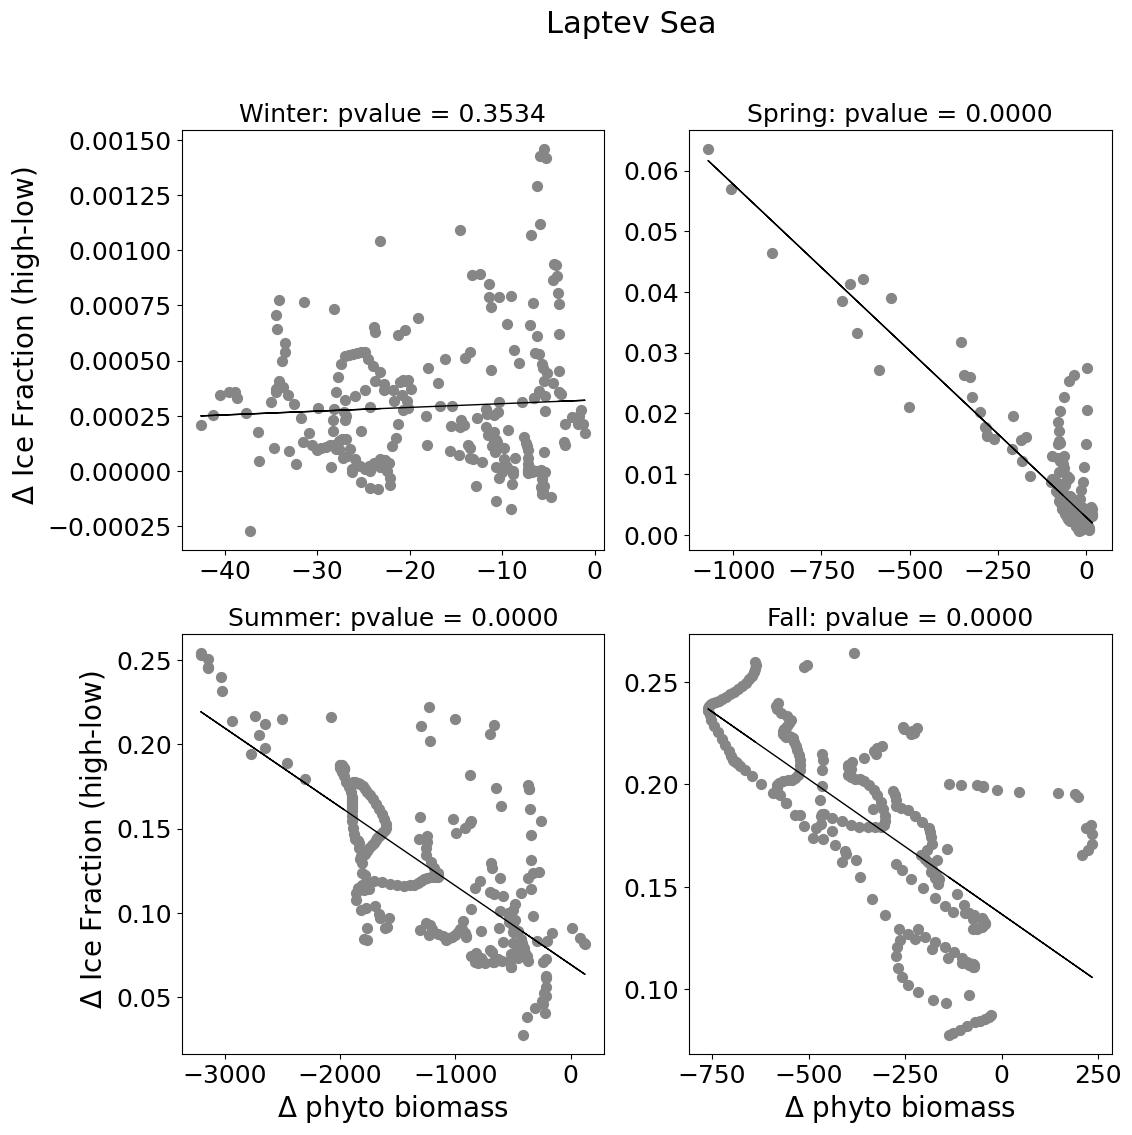

In [106]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(2,2,1) 
X1 = high_low_ice_years_winter_diff[149:170,270:325].flatten()
Y1 = np.nanmean(high_low_ice[list(range(2)) + [-1],149:170,270:325],axis=0).flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Winter: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(2,2,2) 
X2 = high_low_ice_years_spring_diff[149:170,270:325].flatten()
Y2 = np.nanmean(high_low_ice[2:5,149:170,270:325],axis=0).flatten()
XX2= X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2 = Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Spring: pvalue = {res2.pvalue:.4f}')

ax = fig.add_subplot(2,2,3) 
ax.set_xlabel('$\u0394$ phyto biomass')
ax.set_ylabel(f' $\u0394$ {caption}')
X3 = high_low_ice_years_summer_diff[149:170,270:325].flatten()
Y3 = np.nanmean(high_low_ice[5:8,149:170,270:325],axis=0).flatten()
XX3= X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Summer: pvalue = {res3.pvalue:.4f}')

ax = fig.add_subplot(2,2,4) 
ax.set_xlabel('$\u0394$ phyto biomass')
X4 = high_low_ice_years_fall_diff[149:170,270:325].flatten()
Y4 = np.nanmean(high_low_ice[8:11,149:170,270:325],axis=0).flatten()
XX4= X4[~np.isnan(Y4) & ~np.isnan(X4)]
YY4 = Y4[~np.isnan(Y4) & ~np.isnan(X4)]
res4 = stats.linregress(XX4, YY4)
YYY4 = res4.intercept + res4.slope*XX4
ax.scatter(XX4, YY4, color = cmap1(4), s = 50)
ax.plot(XX4, YYY4, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Fall: pvalue = {res4.pvalue:.4f}')
region = 'Laptev Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_quarterly_scatter_{variable}_{phyto_variable}_diff.png',dpi=600, bbox_inches='tight')

In [107]:
res1

LinregressResult(slope=1.701201671364466e-06, intercept=0.0003219271252264051, rvalue=0.059423880695554744, pvalue=0.3533554007176971, stderr=1.8294971217130716e-06)

In [108]:
res2

LinregressResult(slope=-5.488629644434608e-05, intercept=0.0028619596581618756, rvalue=-0.8948690648113987, pvalue=1.8680567449853898e-87, stderr=1.7525256597452867e-06)

In [109]:
res3

LinregressResult(slope=-4.6717430892158224e-05, intercept=0.06946634995231779, rvalue=-0.726957302465456, pvalue=1.0308944609785071e-41, stderr=2.8250830417257807e-06)

In [110]:
res4

LinregressResult(slope=-0.00013181954802128038, intercept=0.1366292693350838, rvalue=-0.6954504843160088, pvalue=6.9617422506513276e-37, stderr=8.719472314896736e-06)

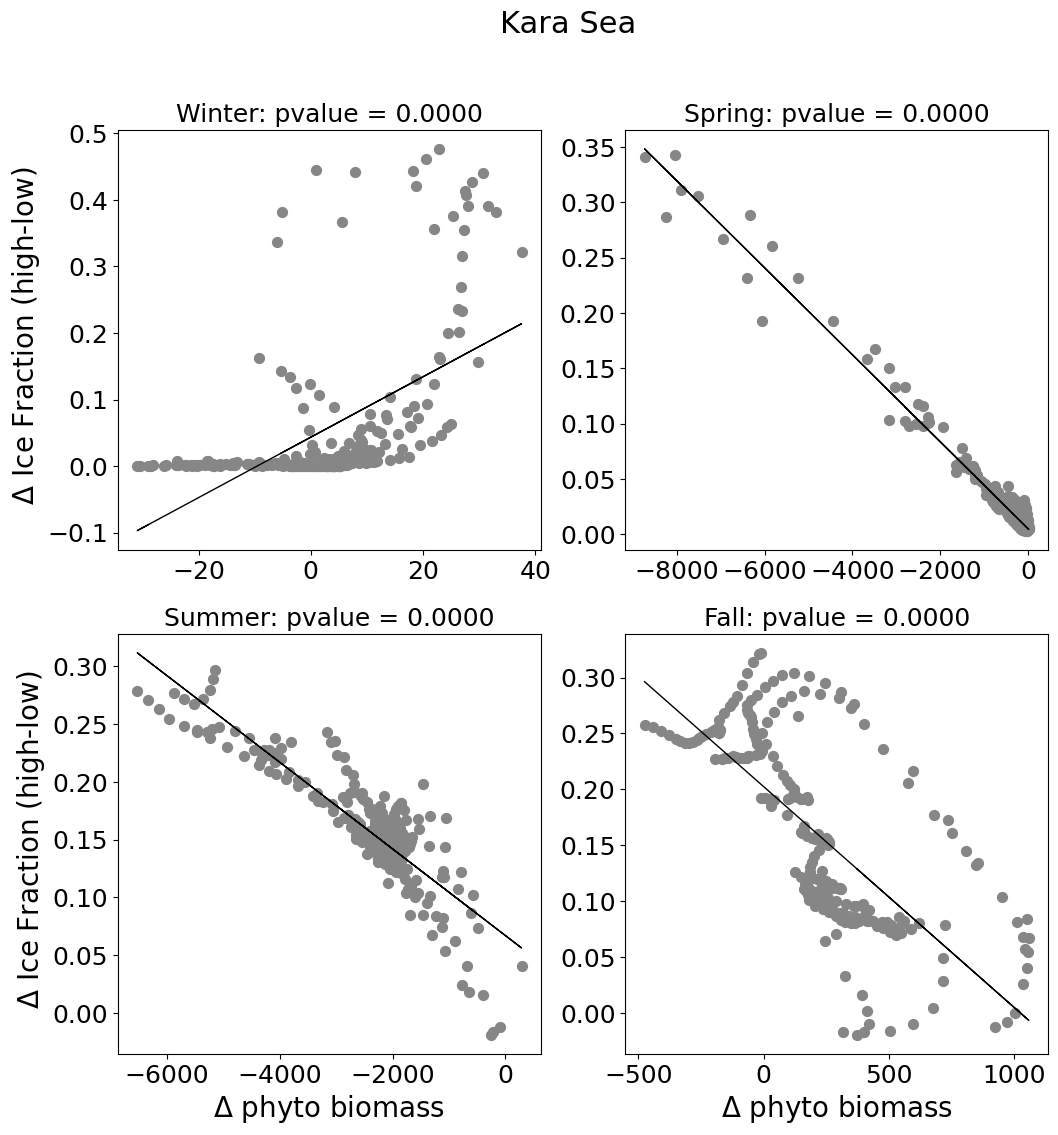

In [111]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(2,2,1) 
X1 = high_low_ice_years_winter_diff[149:170,233:270].flatten()
Y1 = np.nanmean(high_low_ice[list(range(2)) + [-1],149:170,233:270],axis=0).flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Winter: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(2,2,2) 
X2 = high_low_ice_years_spring_diff[149:170,233:270].flatten()
Y2 = np.nanmean(high_low_ice[2:5,149:170,233:270],axis=0).flatten()
XX2= X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2 = Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Spring: pvalue = {res2.pvalue:.4f}')

ax = fig.add_subplot(2,2,3) 
ax.set_xlabel('$\u0394$ phyto biomass')
ax.set_ylabel(f' $\u0394$ {caption}')
X3 = high_low_ice_years_summer_diff[149:170,233:270].flatten()
Y3 = np.nanmean(high_low_ice[5:8,149:170,233:270],axis=0).flatten()
XX3= X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Summer: pvalue = {res3.pvalue:.4f}')

ax = fig.add_subplot(2,2,4) 
ax.set_xlabel('$\u0394$ phyto biomass')
X4 = high_low_ice_years_fall_diff[149:170,233:270].flatten()
Y4 = np.nanmean(high_low_ice[8:11,149:170,233:270],axis=0).flatten()
XX4= X4[~np.isnan(Y4) & ~np.isnan(X4)]
YY4 = Y4[~np.isnan(Y4) & ~np.isnan(X4)]
res4 = stats.linregress(XX4, YY4)
YYY4 = res4.intercept + res4.slope*XX4
ax.scatter(XX4, YY4, color = cmap1(4), s = 50)
ax.plot(XX4, YYY4, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Fall: pvalue = {res4.pvalue:.4f}')
region = 'Kara Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region}_quarterly_scatter_{variable}_{phyto_variable}_diff.png',dpi=600, bbox_inches='tight')

In [112]:
res1

LinregressResult(slope=0.004540133910985292, intercept=0.043493167413309386, rvalue=0.5432263054245803, pvalue=5.617276574862431e-21, stderr=0.00044115678293483925)

In [113]:
res2

LinregressResult(slope=-3.926194230528169e-05, intercept=0.0052025912725832055, rvalue=-0.9900964442514376, pvalue=9.53665626983007e-218, stderr=3.499988813685002e-07)

In [114]:
res3

LinregressResult(slope=-3.749181706617502e-05, intercept=0.06680771709459711, rvalue=-0.8850684977247231, pvalue=5.332498280403762e-86, stderr=1.2396025334415375e-06)

In [115]:
res4

LinregressResult(slope=-0.00019774858546307378, intercept=0.20247293811482697, rvalue=-0.7169287868418115, pvalue=1.5990030165212382e-41, stderr=1.2089298479392162e-05)

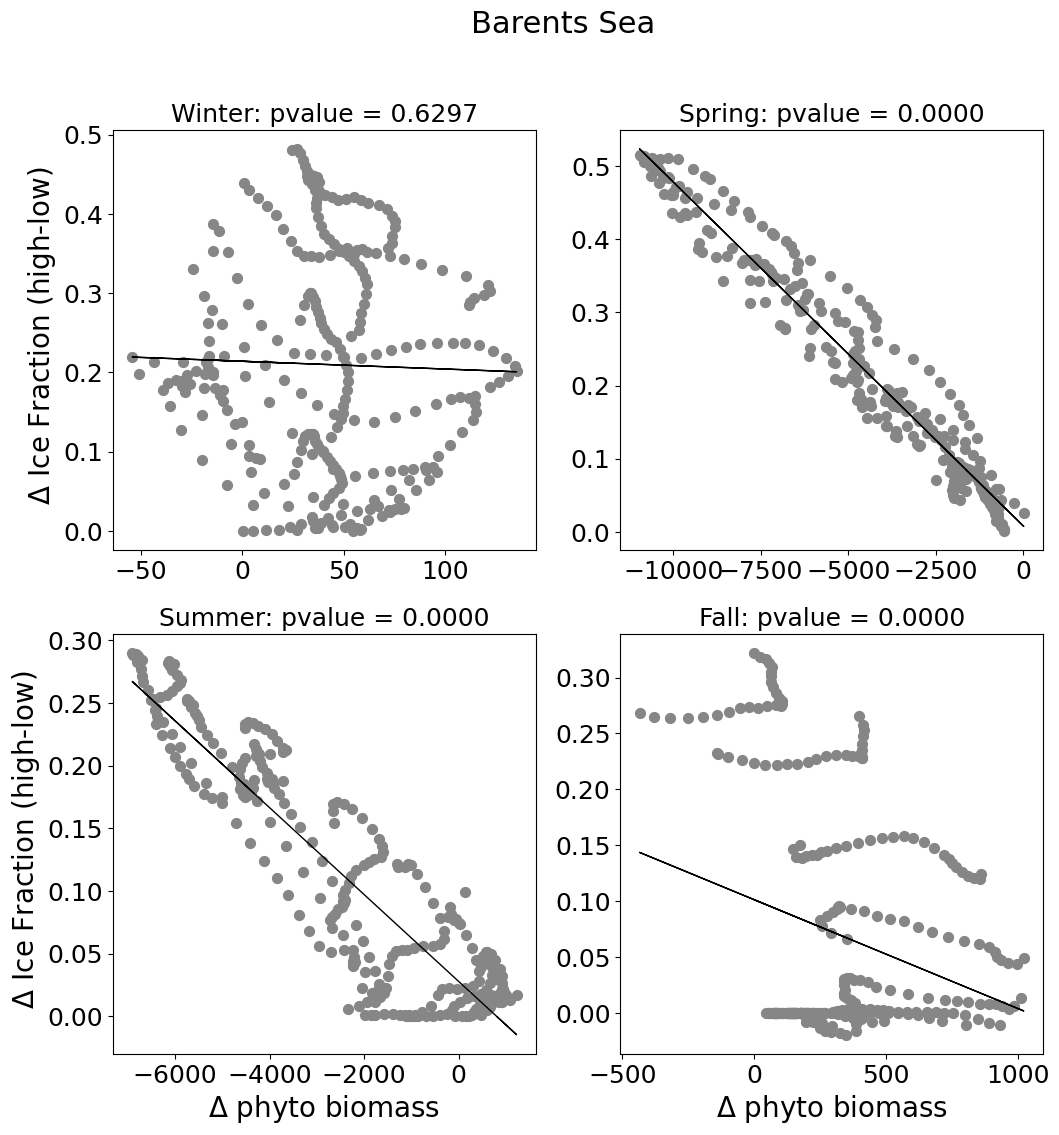

In [116]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(2,2,1) 
X1 = high_low_ice_years_winter_diff[149:170,205:233].flatten()
Y1 = np.nanmean(high_low_ice[list(range(2)) + [-1],149:170,205:233],axis=0).flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Winter: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(2,2,2) 
X2 = high_low_ice_years_spring_diff[149:170,205:233].flatten()
Y2 = np.nanmean(high_low_ice[2:5,149:170,205:233],axis=0).flatten()
XX2= X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2 = Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Spring: pvalue = {res2.pvalue:.4f}')

ax = fig.add_subplot(2,2,3) 
ax.set_xlabel('$\u0394$ phyto biomass')
ax.set_ylabel(f' $\u0394$ {caption}')
X3 = high_low_ice_years_summer_diff[149:170,205:233].flatten()
Y3 = np.nanmean(high_low_ice[5:8,149:170,205:233],axis=0).flatten()
XX3= X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Summer: pvalue = {res3.pvalue:.4f}')

ax = fig.add_subplot(2,2,4) 
ax.set_xlabel('$\u0394$ phyto biomass')
X4 = high_low_ice_years_fall_diff[149:170,205:233].flatten()
Y4 = np.nanmean(high_low_ice[8:11,149:170,205:233],axis=0).flatten()
XX4= X4[~np.isnan(Y4) & ~np.isnan(X4)]
YY4 = Y4[~np.isnan(Y4) & ~np.isnan(X4)]
res4 = stats.linregress(XX4, YY4)
YYY4 = res4.intercept + res4.slope*XX4
ax.scatter(XX4, YY4, color = cmap1(4), s = 50)
ax.plot(XX4, YYY4, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Fall: pvalue = {res4.pvalue:.4f}')
region = 'Barents Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_quarterly_scatter_{variable}_{phyto_variable}_diff.png',dpi=600, bbox_inches='tight')

In [117]:
res1

LinregressResult(slope=-9.772040722294461e-05, intercept=0.21393637259189496, rvalue=-0.02833373742522655, pvalue=0.6296729590330401, stderr=0.0002024454443802615)

In [118]:
res2

LinregressResult(slope=-4.701052157157662e-05, intercept=0.007898836008872173, rvalue=-0.9771410027752832, pvalue=4.667535454445065e-197, stderr=6.00601264174481e-07)

In [119]:
res3

LinregressResult(slope=-3.4645044028182736e-05, intercept=0.027837321637220955, rvalue=-0.9033417841445885, pvalue=1.2698007120686692e-108, stderr=9.659792505758383e-07)

In [120]:
res4

LinregressResult(slope=-9.74157004972267e-05, intercept=0.1012271688857558, rvalue=-0.2563725381779296, pvalue=9.144431984297028e-06, stderr=2.1567280321556507e-05)

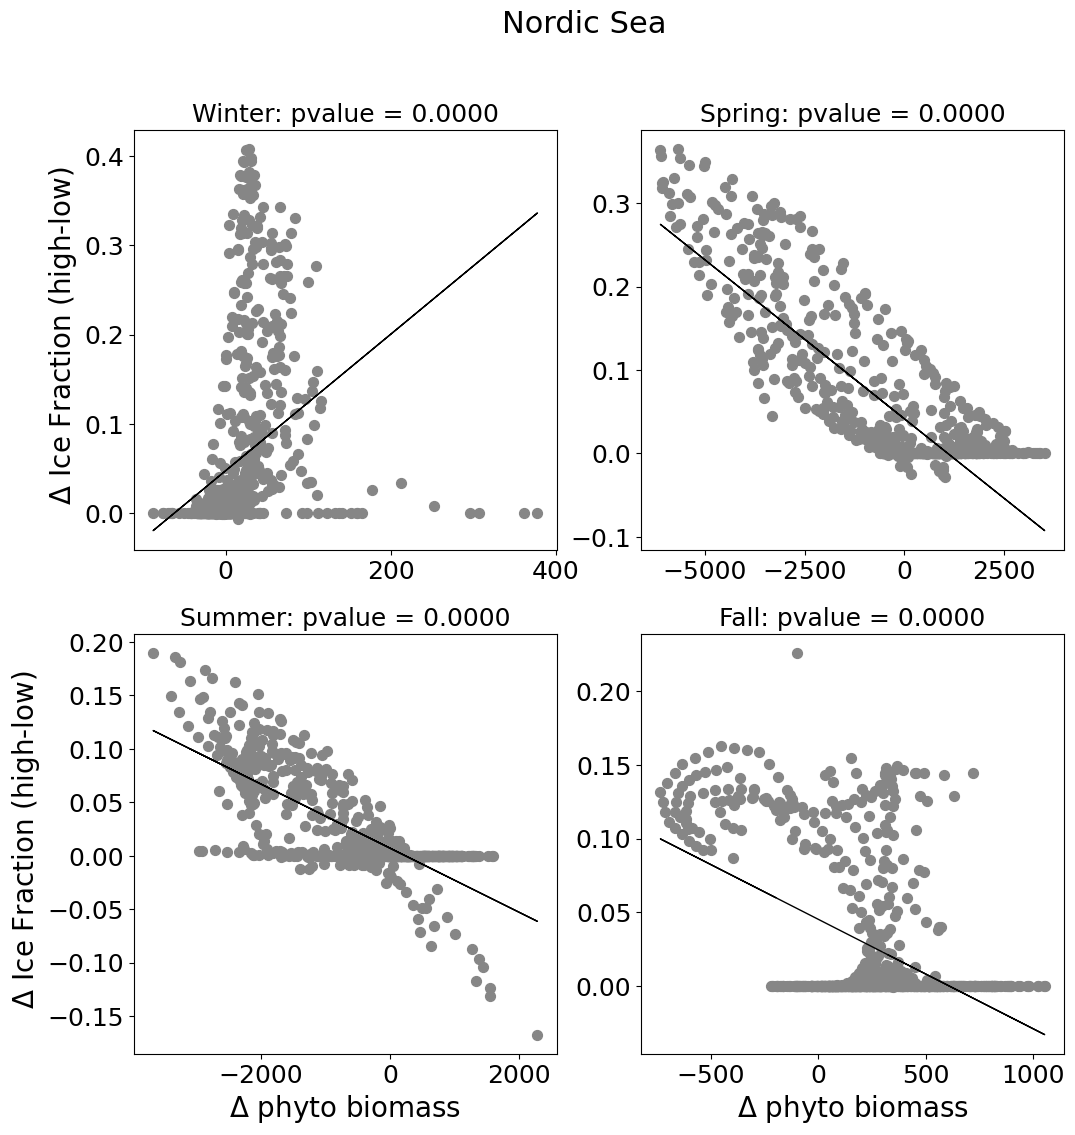

In [121]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(2,2,1) 
X1 = high_low_ice_years_winter_diff[149:170,155:205].flatten()
Y1 = np.nanmean(high_low_ice[list(range(2)) + [-1],149:170,155:205],axis=0).flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Winter: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(2,2,2) 
X2 = high_low_ice_years_spring_diff[149:170,155:205].flatten()
Y2 = np.nanmean(high_low_ice[2:5,149:170,155:205],axis=0).flatten()
XX2= X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2 = Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Spring: pvalue = {res2.pvalue:.4f}')

ax = fig.add_subplot(2,2,3) 
ax.set_xlabel('$\u0394$ phyto biomass')
ax.set_ylabel(f' $\u0394$ {caption}')
X3 = high_low_ice_years_summer_diff[149:170,155:205].flatten()
Y3 = np.nanmean(high_low_ice[5:8,149:170,155:205],axis=0).flatten()
XX3= X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Summer: pvalue = {res3.pvalue:.4f}')

ax = fig.add_subplot(2,2,4) 
ax.set_xlabel('$\u0394$ phyto biomass')
X4 = high_low_ice_years_fall_diff[149:170,155:205].flatten()
Y4 = np.nanmean(high_low_ice[8:11,149:170,155:205],axis=0).flatten()
XX4= X4[~np.isnan(Y4) & ~np.isnan(X4)]
YY4 = Y4[~np.isnan(Y4) & ~np.isnan(X4)]
res4 = stats.linregress(XX4, YY4)
YYY4 = res4.intercept + res4.slope*XX4
ax.scatter(XX4, YY4, color = cmap1(4), s = 50)
ax.plot(XX4, YYY4, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Fall: pvalue = {res4.pvalue:.4f}')
region = 'Nordic Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_quarterly_scatter_{variable}_{phyto_variable}_diff.png',dpi=600, bbox_inches='tight')

In [122]:
res1

LinregressResult(slope=0.0007638932220929467, intercept=0.04772696006589456, rvalue=0.3199630524340181, pvalue=8.197511729802237e-20, stderr=8.15674334950133e-05)

In [123]:
res2

LinregressResult(slope=-3.8105965055622595e-05, intercept=0.041629726600226555, rvalue=-0.834053406320222, pvalue=7.890941530062568e-201, stderr=9.089209100357537e-07)

In [124]:
res3

LinregressResult(slope=-2.9921973304492815e-05, intercept=0.007129617325922044, rvalue=-0.7758750406444568, pvalue=5.385579582424015e-156, stderr=8.773777036439908e-07)

In [125]:
res4

LinregressResult(slope=-7.41762183253866e-05, intercept=0.04518740568469856, rvalue=-0.4865212624669906, pvalue=4.630431457388153e-47, stderr=4.803374945397474e-06)